In [1]:
from itertools import product
import math
from collections import namedtuple
from subprocess import Popen, PIPE
from copy import copy, deepcopy

from pyRDTP.molecule import Molecule
from pyRDTP.geomio import file_to_mol
import networkx as nx
import numpy as np
from scipy.spatial import Voronoi
from ase.io.vasp import read_vasp
from constants import CORDERO, METALS, MOL_ELEM
import numpy as np
from itertools import product
from ase.atoms import Atoms
import tempfile
from ase.neighborlist import (
    natural_cutoffs,
    build_neighbor_list,
    get_connectivity_matrix,
)
from typing import Union
import scipy.sparse as sp
from scipy.spatial import Voronoi
from networkx import (
    Graph,
    from_scipy_sparse_matrix,
    from_scipy_sparse_array,
    set_node_attributes,
    get_node_attributes,
    neighbors,
    to_scipy_sparse_matrix,
    from_edgelist,
    get_edge_attributes,
)


/home/smorandi/anaconda3/envs/GNN/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def get_voronoi_neighbourlist(
    atom: Atoms, scale_factor: float, tolerance: float
) -> np.ndarray:
    """Get connectivity matrix from voronoi analysis.

    Args:
        atoms (Atoms): ase atoms object
        scale_factor (float, optional): Scale factor for covalent radii of metal atoms.
        tolerance (float, optional): Tolerance for voronoi analysis. Defaults to 0.25.

    Returns:
        np.ndarray: 2D numpy array of connectivity matrix. [[1, 0], [0, 1]]
    """
    coords_arr = np.copy(atom.positions)
    coords_arr = np.expand_dims(coords_arr, axis=0)
    coords_arr = np.repeat(coords_arr, 27, axis=0)
    mirrors = [-1, 0, 1]
    mirrors = np.asarray(list(product(mirrors, repeat=3)))
    mirrors = np.expand_dims(mirrors, 1)
    mirrors = np.repeat(mirrors, coords_arr.shape[1], axis=1)
    corrected_coords = np.reshape(
        coords_arr + mirrors,
        (coords_arr.shape[0] * coords_arr.shape[1], coords_arr.shape[2]),
    )
    corrected_coords = np.dot(corrected_coords, atom.get_cell())
    translator = np.tile(np.arange(coords_arr.shape[1]), coords_arr.shape[0])
    vor_bonds = Voronoi(corrected_coords)
    pairs_corr = translator[vor_bonds.ridge_points]
    pairs_corr = np.unique(np.sort(pairs_corr, axis=1), axis=0)
    true_arr = pairs_corr[:, 0] == pairs_corr[:, 1]
    true_arr = np.argwhere(true_arr)
    pairs_corr = np.delete(pairs_corr, true_arr, axis=0)
    dst_d = {}
    pairs_lst = []
    for pair in pairs_corr:
        distance = atom.get_distance(pair[0], pair[1])
        elem_pair = (atom[pair[0]].symbol, atom[pair[1]].symbol)
        if elem_pair not in dst_d:
            dst_d[elem_pair] = (CORDERO[atom[pair[0]].symbol] + CORDERO[atom[pair[1]].symbol] + tolerance)
            if atom[pair[0]].symbol in METALS:
                dst_d[elem_pair] += (scale_factor - 1) * CORDERO[atom[pair[0]].symbol]
            if atom[pair[1]].symbol in METALS:
                dst_d[elem_pair] += (scale_factor - 1) * CORDERO[atom[pair[1]].symbol]
        if distance < dst_d[elem_pair]:
            pairs_lst.append(pair)
    if len(pairs_lst) == 0:
        return np.array([])
    else:
        return np.sort(np.array(pairs_lst), axis=1)

# TEST

In [51]:
TEST_SAMPLE = "/WAREHOUSE/GNN/DFT_data/FG_dataset/aromatics/ni-66S1-a/"
atoms = read_vasp(TEST_SAMPLE + "CONTCAR")  # ASE
molecule = file_to_mol(TEST_SAMPLE + "CONTCAR", "contcar", False)  #pyRDTP

In [52]:
print(molecule.cell_p)

[[ 8.61789516  0.          0.        ]
 [ 4.30894758  7.46331613  0.        ]
 [ 0.          0.         20.        ]]


In [53]:
print(molecule.cell_p.direct)

[[ 8.61789516  0.          0.        ]
 [ 4.30894758  7.46331613  0.        ]
 [ 0.          0.         20.        ]]


In [57]:
molecule.coords_array("direct")

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.66666667e-01,  1.66666667e-01,  0.00000000e+00],
       [ 3.33333333e-01,  3.33333333e-01,  0.00000000e+00],
       [ 5.00000000e-01,  0.00000000e+00,  0.00000000e+00],
       [ 6.66666667e-01,  1.66666667e-01,  0.00000000e+00],
       [ 8.33333333e-01,  3.33333333e-01,  0.00000000e+00],
       [ 0.00000000e+00,  5.00000000e-01,  0.00000000e+00],
       [ 1.66666667e-01,  6.66666667e-01,  0.00000000e+00],
       [ 3.33333333e-01,  8.33333333e-01,  0.00000000e+00],
       [ 5.00000000e-01,  5.00000000e-01,  0.00000000e+00],
       [ 6.66666667e-01,  6.66666667e-01,  0.00000000e+00],
       [ 8.33333333e-01,  8.33333333e-01,  0.00000000e+00],
       [ 1.66666667e-01,  0.00000000e+00,  1.01562868e-01],
       [ 0.00000000e+00,  3.33333333e-01,  1.01562868e-01],
       [ 3.33333333e-01,  1.66666667e-01,  1.01562868e-01],
       [ 6.66666667e-01,  0.00000000e+00,  1.01562868e-01],
       [ 5.00000000e-01,  3.33333333e-01

In [55]:
atoms.get_cell()

Cell([[8.61789515514497, 0.0, 0.0], [4.30894757757248, 7.46331613150638, 0.0], [0.0, 0.0, 20.0]])

[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.66666667e-01 1.66666667e-01 0.00000000e+00]
 [3.33333333e-01 3.33333333e-01 0.00000000e+00]
 [5.00000000e-01 0.00000000e+00 0.00000000e+00]
 [6.66666667e-01 1.66666667e-01 0.00000000e+00]
 [8.33333333e-01 3.33333333e-01 0.00000000e+00]
 [0.00000000e+00 5.00000000e-01 0.00000000e+00]
 [1.66666667e-01 6.66666667e-01 0.00000000e+00]
 [3.33333333e-01 8.33333333e-01 0.00000000e+00]
 [5.00000000e-01 5.00000000e-01 0.00000000e+00]
 [6.66666667e-01 6.66666667e-01 0.00000000e+00]
 [8.33333333e-01 8.33333333e-01 0.00000000e+00]
 [1.66666667e-01 0.00000000e+00 1.01562868e-01]
 [0.00000000e+00 3.33333333e-01 1.01562868e-01]
 [3.33333333e-01 1.66666667e-01 1.01562868e-01]
 [6.66666667e-01 0.00000000e+00 1.01562868e-01]
 [5.00000000e-01 3.33333333e-01 1.01562868e-01]
 [8.33333333e-01 1.66666667e-01 1.01562868e-01]
 [1.66666667e-01 5.00000000e-01 1.01562868e-01]
 [1.81533379e-17 8.33333333e-01 1.01562868e-01]
 [3.33333333e-01 6.66666667e-01 1.015628

In [33]:
adsorbate_indexes = {atom.index for atom in atoms if atom.symbol not in METALS}
print(adsorbate_indexes)

{48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60}


In [34]:
neighbour_list = get_voronoi_neighbourlist(atoms, 1.5, 0.5)
metal_neighbours = set()
for pair in neighbour_list:  # first order neighbours
        if (pair[0] in adsorbate_indexes) and (atoms[pair[1]].symbol in METALS):  # adsorbate-metal
            metal_neighbours.add(pair[1])
        elif (pair[1] in adsorbate_indexes) and (atoms[pair[0]].symbol in METALS):  # metal-adsorbate
            metal_neighbours.add(pair[0])
        else:  # adsorbate-adsorbate and metal-metal
            continue
ensemble =  Atoms(atoms[[*adsorbate_indexes, *metal_neighbours]])
ensemble_neighbour_list = get_voronoi_neighbourlist(ensemble, 1.5, 0.5)
ll = []
#print(metal_neighbours)
for pair in ensemble_neighbour_list:
    print(pair)
    if (ensemble[pair[0]].symbol in METALS) and (ensemble[pair[1]].symbol in METALS):
        # do nothing
        continue
    else:
        ll.append(pair)
print(ensemble_neighbour_list.shape, len(ll))
nx_graph = Graph()
nx_graph.add_nodes_from(range(len(ensemble)))
nx_graph.add_edges_from(ll)
set_node_attributes(nx_graph, {i: ensemble[i].symbol for i in range(len(ensemble))}, "element")

[ 0 12]
[1 7]
[ 1 16]
[2 9]
[ 2 15]
[ 3 10]
[ 3 19]
[4 6]
[ 4 17]
[ 5 11]
[6 7]
[ 6 11]
[ 6 16]
[ 6 17]
[ 6 18]
[7 8]
[ 7 16]
[ 7 17]
[ 7 18]
[8 9]
[ 8 12]
[ 8 14]
[ 8 15]
[ 8 18]
[ 8 19]
[ 9 10]
[ 9 15]
[ 9 18]
[ 9 19]
[10 11]
[10 17]
[10 19]
[11 17]
[11 19]
[12 13]
[12 14]
[12 15]
[12 18]
[13 14]
[13 16]
[13 18]
[14 15]
[14 18]
[15 18]
[15 19]
[16 17]
[16 18]
[17 18]
[17 19]
[18 19]
(50, 2) 38


In [35]:
# For each node in the graph, print the index, the element, the number of neighbours
for node in nx_graph.nodes:
    print(node, nx_graph.nodes[node]["element"], nx_graph.degree[node])

0 H 1
1 H 2
2 H 2
3 H 2
4 H 2
5 H 1
6 C 6
7 C 6
8 C 7
9 C 6
10 C 5
11 C 5
12 S 6
13 Ni 1
14 Ni 2
15 Ni 4
16 Ni 3
17 Ni 5
18 Ni 5
19 Ni 5


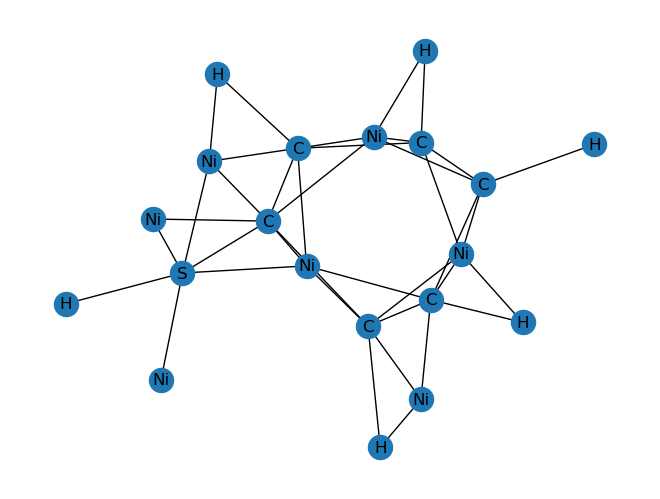

In [36]:
# Print graph with node labels as element symbols
nx.draw(nx_graph, with_labels=True, labels={i: nx_graph.nodes[i]["element"] for i in range(len(ensemble))})

In [15]:
atoms[48:]

Atoms(symbols='H9C4NO2', pbc=True, cell=[7.47363, 8.6298045846, 20.0])

In [16]:
for atom in atoms[48:]:
    print(type(atom.symbol), atom.position, atom.x, atom.y, atom.z, atom.index)
    

<class 'str'> [4.78074959 2.13922477 8.24247583] 4.780749594918074 2.1392247668267994 8.242475830353664 0
<class 'str'> [5.50680163 3.88291526 9.62204525] 5.506801630510825 3.8829152624869767 9.622045251922518 1
<class 'str'> [ 6.51392491  5.8831065  10.62057063] 6.513924906676323 5.883106503068694 10.620570634652587 2
<class 'str'> [6.10812093 7.42253972 9.8174713 ] 6.108120926843354 7.4225397151907035 9.817471303027592 3
<class 'str'> [6.73599168 6.06850965 8.84643539] 6.735991675621807 6.068509645338101 8.846435387479014 4
<class 'str'> [4.29664236 6.27036275 8.5177531 ] 4.29664236268626 6.270362750563295 8.517753103994524 5
<class 'str'> [ 4.06686532  5.89028951 11.56914719] 4.066865317779196 5.890289511418459 11.56914719135769 6
<class 'str'> [ 2.70298447  5.87989853 10.40393092] 2.7029844707969866 5.879898526244453 10.4039309157133 7
<class 'str'> [ 3.65836217  7.36680175 10.64771396] 3.6583621723298623 7.366801746138109 10.647713961600429 8
<class 'str'> [3.69176203 3.70699561 8

In [17]:
dir(atoms[49])

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 'a',
 'atoms',
 'b',
 'c',
 'charge',
 'cut_reference_to_atoms',
 'data',
 'delete',
 'get',
 'get_raw',
 'index',
 'magmom',
 'mass',
 'momentum',
 'number',
 'position',
 'scaled_position',
 'set',
 'symbol',
 'tag',
 'x',
 'y',
 'z']

In [21]:
def atoms_to_graph(atoms: Atoms, 
                   voronoi_tolerance: float,
                   scaling_factor: float,
                   second_order: bool) -> Graph:
    """
    Convert ase Atoms object to NetworkX graph with the Voronoi tessellation algorithm.
    Args: 
        atoms (ase.Atoms): ase Atoms object.
        voronoi_tolerance (float): Tolerance of the tessellation algorithm for edge creation.
        second_order (bool): Whether to include the 2-hop metal atoms neighbours.
        scaling_factor (float): Scaling factor applied to metal atomic radii from Cordero et al.
    Returns:
        graph (nx.Graph): NetworkX graph object representing the adsorbate-metal system.
    """
    # 1) Get connectivity list for the whole system (adsorbate + metal slab)
    adsorbate_indexes = {atom.index for atom in atoms if atom.symbol not in METALS}
    metal_neighbours = set()
    neighbour_list = get_voronoi_neighbourlist(atoms, voronoi_tolerance, scaling_factor)
    if len(neighbour_list) == 0:
        return Atoms()
    # 2) Get first order metal neighbours
    for pair in neighbour_list:
        if (pair[0] in adsorbate_indexes) and (atoms[pair[1]].symbol in METALS):  # adsorbate-metal
            metal_neighbours.add(pair[1])
        elif (pair[1] in adsorbate_indexes) and (atoms[pair[0]].symbol in METALS):  # metal-adsorbate
            metal_neighbours.add(pair[0])
        else:  # adsorbate-adsorbate and metal-metal
            continue
    # 3) Get second order metal neighbours
    if second_order:
        nl = []
        for metal_atom_index in metal_neighbours:
            for pair in neighbour_list:
                if (pair[0] == metal_atom_index) and (pair[1] not in adsorbate_indexes):
                    nl.append(pair[1])
                elif (pair[1] == metal_atom_index) and (pair[0] not in adsorbate_indexes):
                    nl.append(pair[0])
        for index in nl:
            metal_neighbours.add(index)        
    # 4) Construct graph with the atoms in the ensemble
    ensemble =  atoms[[*adsorbate_indexes, *metal_neighbours]]
    ensemble_neighbour_list = get_voronoi_neighbourlist(ensemble, voronoi_tolerance, scaling_factor)
    print(ensemble_neighbour_list)
    # If not second order, remove connections between metal atoms
    if not second_order:
        # Remove from the array the rows which contain metal-metal connections
        ensemble_neighbour_list = ensemble_neighbour_list[~np.isin(ensemble_neighbour_list[:, 0], metal_neighbours) |
                                                            ~np.isin(ensemble_neighbour_list[:, 1], metal_neighbours)]
    print(ensemble_neighbour_list)
    # Add edges to the graph to make undirected graph
    ensemble_neighbour_list = np.concatenate((ensemble_neighbour_list, ensemble_neighbour_list[:, [1, 0]]), axis=0)
    scipy_coo_matrix = sp.coo_matrix((np.ones(len(ensemble_neighbour_list)), 
                                           (np.array(ensemble_neighbour_list)[:, 0], np.array(ensemble_neighbour_list)[:, 1])))
    nx_graph = from_scipy_sparse_array(scipy_coo_matrix)
    elem_list = [atom.symbol for atom in ensemble]
    set_node_attributes(nx_graph, dict(zip(range(len(elem_list)), elem_list)), "element")
    return nx_graph

In [25]:
nx_graph = atoms_to_graph(atoms, 0.5, 1.5, True)
nx_graph.number_of_nodes(), nx_graph.number_of_edges()
nx_graph[0]["element"]

[[ 0  9]
 [ 0 13]
 [ 0 15]
 [ 0 30]
 [ 1  9]
 [ 1 10]
 [ 1 11]
 [ 1 13]
 [ 1 15]
 [ 2  3]
 [ 2  4]
 [ 2 10]
 [ 2 11]
 [ 3  4]
 [ 3 10]
 [ 3 11]
 [ 4 10]
 [ 4 11]
 [ 5 10]
 [ 5 11]
 [ 5 12]
 [ 5 13]
 [ 5 35]
 [ 6  7]
 [ 6  8]
 [ 6 10]
 [ 6 12]
 [ 7  8]
 [ 7 10]
 [ 7 12]
 [ 8 10]
 [ 8 12]
 [ 9 10]
 [ 9 13]
 [ 9 14]
 [ 9 15]
 [10 11]
 [10 12]
 [10 13]
 [10 14]
 [11 12]
 [11 13]
 [12 13]
 [13 14]
 [13 15]
 [14 15]
 [14 32]
 [15 30]
 [16 17]
 [16 18]
 [16 19]
 [16 29]
 [16 30]
 [16 32]
 [17 19]
 [17 20]
 [17 30]
 [17 31]
 [17 33]
 [18 19]
 [18 21]
 [18 22]
 [18 29]
 [18 30]
 [18 32]
 [18 34]
 [19 20]
 [19 22]
 [19 23]
 [19 29]
 [19 30]
 [19 31]
 [19 32]
 [19 33]
 [19 35]
 [20 23]
 [20 30]
 [20 31]
 [20 33]
 [20 36]
 [21 22]
 [21 24]
 [21 32]
 [21 34]
 [22 23]
 [22 24]
 [22 25]
 [22 27]
 [22 32]
 [22 33]
 [22 34]
 [22 35]
 [23 25]
 [23 26]
 [23 28]
 [23 32]
 [23 33]
 [23 35]
 [23 36]
 [24 25]
 [24 27]
 [24 34]
 [24 35]
 [25 26]
 [25 27]
 [25 28]
 [25 34]
 [25 35]
 [25 36]
 [26 28]
 [26 35]
 

KeyError: 'element'

In [7]:
out

array([[ 0,  1],
       [ 0,  3],
       [ 0, 12],
       [ 0, 15],
       [ 0, 18],
       [ 1,  2],
       [ 1,  3],
       [ 1,  4],
       [ 1, 13],
       [ 1, 15],
       [ 1, 16],
       [ 1, 19],
       [ 2,  4],
       [ 2,  5],
       [ 2, 14],
       [ 2, 16],
       [ 2, 17],
       [ 2, 20],
       [ 3,  4],
       [ 3,  6],
       [ 3,  7],
       [ 3, 15],
       [ 3, 18],
       [ 3, 19],
       [ 3, 21],
       [ 4,  5],
       [ 4,  7],
       [ 4,  8],
       [ 4, 16],
       [ 4, 19],
       [ 4, 20],
       [ 4, 22],
       [ 5,  8],
       [ 5, 17],
       [ 5, 20],
       [ 5, 23],
       [ 6,  7],
       [ 6,  9],
       [ 6, 18],
       [ 6, 21],
       [ 6, 30],
       [ 7,  8],
       [ 7,  9],
       [ 7, 10],
       [ 7, 19],
       [ 7, 21],
       [ 7, 22],
       [ 8, 10],
       [ 8, 11],
       [ 8, 20],
       [ 8, 22],
       [ 8, 23],
       [ 9, 10],
       [ 9, 21],
       [ 9, 33],
       [10, 11],
       [10, 22],
       [10, 34],
       [11, 23

In [43]:
test_dict = {"a":0, "b":1, "c":2}
test_dict.items()

dict_items([('a', 0), ('b', 1), ('c', 2)])

In [44]:
graph

In [51]:
# Get tails of the edges
edge_tails = [edge[0] for edge in graph.edges]
# Get heads of the edges
edge_heads = [edge[1] for edge in graph.edges]
# Get node labels
elem_lst = [graph.nodes[node]['element'] for node in graph.nodes]

In [50]:
tuple(edge_tails)

(0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9, 9, 10, 10, 10, 14, 14, 15, 16)

In [52]:
elem_lst

['H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'C',
 'C',
 'C',
 'C',
 'N',
 'O',
 'O',
 'Co',
 'Co']

In [58]:
ase_atoms[0,2,3,4, 20, 50, 60, 60, 60]

Atoms(symbols='Co5HC3', pbc=True, cell=[7.47363, 8.6298045846, 20.0], constraint=FixAtoms(indices=[0, 1, 2, 3, 4]))

In [136]:
graph = atoms_to_graph(ase_atoms, voronoi_tolerance=0.5, scaling_factor=1.5, second_order=False)
# Print node attributes for each node
print(nx.get_node_attributes(graph, 'element'))

(50, 2)
(0,)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [107]:
print(graph)

Graph with 37 nodes and 130 edges


In [74]:
a = {1,2,3,4,5}

In [75]:
type(a)

set

In [76]:
a

{1, 2, 3, 4, 5}

In [77]:
a.add(6)

In [78]:
a

{1, 2, 3, 4, 5, 6}

In [79]:
a.add(6)

In [80]:
a

{1, 2, 3, 4, 5, 6}

In [83]:
import numpy as np

# create a sample numpy array of dimension N*2
arr = np.array([[1, 2],
                [3, 4],
                [5, 4],
                [7, 8], 
                [4, 10]])

# select a specific value
val = 4

# use boolean indexing to select the rows that contain the value in either column
mask = np.logical_or(arr[:, 0] == val, arr[:, 1] == val)
rows_with_val = arr[mask]

print(rows_with_val)

[[ 3  4]
 [ 5  4]
 [ 4 10]]


In [92]:
get_voronoi_neighbourlist(ase_atoms, scale_factor=1.5, tolerance=0.5).shape

(250, 2)

In [121]:
arr[:, [1,0]]

array([[ 2,  1],
       [ 4,  3],
       [ 4,  5],
       [ 8,  7],
       [10,  4]])

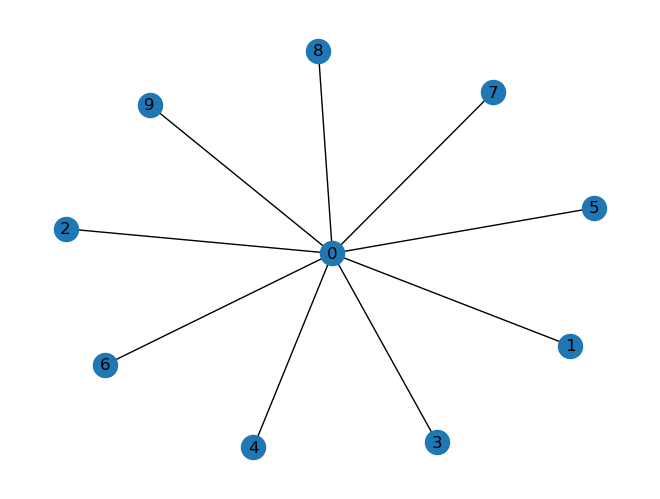

In [2]:
# Create test networkx graph
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
G.add_edges_from([(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9)])
nx.draw(G, with_labels=True)

In [4]:
G.is_directed()

False

In [2]:
import torch 
from torch_geometric.data import Data
from sklearn.preprocessing import OneHotEncoder
import numpy as np

ENCODER = OneHotEncoder().fit(np.array(MOL_ELEM + METALS).reshape(-1, 1))  
ELEMENT_LIST = list(ENCODER.categories_[0])                                
FULL_ELEM_LIST = METALS + MOL_ELEM
FULL_ELEM_LIST.sort()

# Name of chemical families included in the dataset
FG_RAW_GROUPS = ["amides", "amidines", "group2", "group2b",
                 "group3S", "group3N", "group4", "carbamate_esters",
                 "oximes", "aromatics", "aromatics2",
                 "gas_amides", "gas_amidines", "gas_aromatics",
                 "gas_aromatics2", "gas_carbamate_esters", "gas_group2",
                 "gas_group2b", "gas_group3N", "gas_group3S",
                 "gas_group4", "gas_oximes"]  # Raw Datasets names defined during DFT data generation
FG_FAMILIES = ["Amides", "Amidines", "$C_{x}H_{y}O_{(0,1)}$", "$C_{x}H_{y}O_{(0,1)}$",
               "$C_{x}H_{y}S$", "$C_{x}H_{y}N$", "$C_{x}H_{y}O_{(2,3)}$", "Carbamates",
               "Oximes", "Aromatics", "Aromatics", 
               "Amides", "Amidines", "Aromatics", 
               "Aromatics", "Carbamates", "$C_{x}H_{y}O_{(0,1)}$", 
               "$C_{x}H_{y}O_{(0,1)}$", "$C_{x}H_{y}N$", "$C_{x}H_{y}S$", 
               "$C_{x}H_{y}O_{(2,3)}$", "Oximes"]  # Proper chemical family name used in manuscipts
FAMILY_DICT = dict(zip(FG_RAW_GROUPS, FG_FAMILIES))  

In [3]:
dat_path = "../../data/FG_dataset/aromatics/pre_051_False_151.dat"
data_list = []
with open(dat_path, 'r') as infile:
    lines = infile.readlines()
    split_n = lambda x, n: [x[i:i+n] for i in range(0, len(x), n)]
    splitted = split_n(lines, 5)  # Each sample =  5 text lines
    for block in splitted:        
        to_int = lambda x: [float(i) for i in x]
        _, elem, source, target, energy = block
        element_list = elem.split()
        counter = 0
        for element in element_list:
            if element in METALS:
                counter += 1
        if counter == 0:
            continue                     
        elem_array = np.array(elem.split()).reshape(-1, 1)
        elem_enc = ENCODER.transform(elem_array).toarray()
        x = torch.tensor(elem_enc, dtype=torch.float)         # Node feature matrix
        edge_index = torch.tensor([to_int(source.split()),    # Edge list COO format
                                   to_int(target.split())],
                                   dtype=torch.long)       
        y = torch.tensor([float(energy)], dtype=torch.float)  # Graph label (Edft - Eslab)
        family = FAMILY_DICT["aromatics"]                    # Chemical family of the adsorbate/molecule
        data = Data(x=x, edge_index=edge_index, y=y, ener=y, family=family)
        data = Data(x=x, edge_index=edge_index, y=y, ener=y, family=family)
        data_list.append(data)              

/scratch/ipykernel_643890/4066138630.py:20: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  edge_index = torch.tensor([to_int(source.split()),    # Edge list COO format
/scratch/ipykernel_643890/4066138630.py:20: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  edge_index = torch.tensor([to_int(source.split()),    # Edge list COO format
/scratch/ipykernel_643890/4066138630.py:20: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  edge_index = torch.tensor([to_int(source.split()),    # Edge list COO format
/scratch/ipykernel_643890/4066138630.py:20: DeprecationWarning: an integer is required (got type float).  Implic

In [4]:
data_list

[Data(x=[12, 19], edge_index=[2, 24], y=[1], ener=[1], family='Aromatics'),
 Data(x=[21, 19], edge_index=[2, 86], y=[1], ener=[1], family='Aromatics'),
 Data(x=[18, 19], edge_index=[2, 40], y=[1], ener=[1], family='Aromatics'),
 Data(x=[23, 19], edge_index=[2, 86], y=[1], ener=[1], family='Aromatics'),
 Data(x=[10, 19], edge_index=[2, 20], y=[1], ener=[1], family='Aromatics'),
 Data(x=[26, 19], edge_index=[2, 92], y=[1], ener=[1], family='Aromatics'),
 Data(x=[17, 19], edge_index=[2, 40], y=[1], ener=[1], family='Aromatics'),
 Data(x=[17, 19], edge_index=[2, 40], y=[1], ener=[1], family='Aromatics'),
 Data(x=[18, 19], edge_index=[2, 72], y=[1], ener=[1], family='Aromatics'),
 Data(x=[20, 19], edge_index=[2, 40], y=[1], ener=[1], family='Aromatics'),
 Data(x=[25, 19], edge_index=[2, 84], y=[1], ener=[1], family='Aromatics'),
 Data(x=[12, 19], edge_index=[2, 28], y=[1], ener=[1], family='Aromatics'),
 Data(x=[20, 19], edge_index=[2, 74], y=[1], ener=[1], family='Aromatics'),
 Data(x=[18,

In [5]:
import sys
sys.path.append("../../src")
from gnn_eads.graph_tools import plotter


In [6]:
data_list[0].is_directed()

False

In [7]:
data_list[0].edge_index

tensor([[ 0,  1,  2,  3,  4,  5,  6,  6,  7,  8,  9,  9, 10, 10,  6,  7,  8,  9,
          7, 10,  8,  9, 10, 11],
        [10, 10,  6,  7,  8,  9,  7, 10,  8,  9, 10, 11,  0,  1,  2,  3,  4,  5,
          6,  6,  7,  8,  9,  9]])

In [8]:
data_list[0].x

tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0

In [10]:
import torch
import sys
sys.path.append("../../src")
from gnn_eads.graph_tools import plotter

In [11]:
loader = torch.load("../../scripts/TEMPLATE/train_loader.pth")

In [12]:
loader.dataset[0]

Data(x=[37, 19], edge_index=[2, 458], y=[1], ener=[1], family='$C_{x}H_{y}O_{(0,1)}$', formula='C20H4O1-Fe3   ')

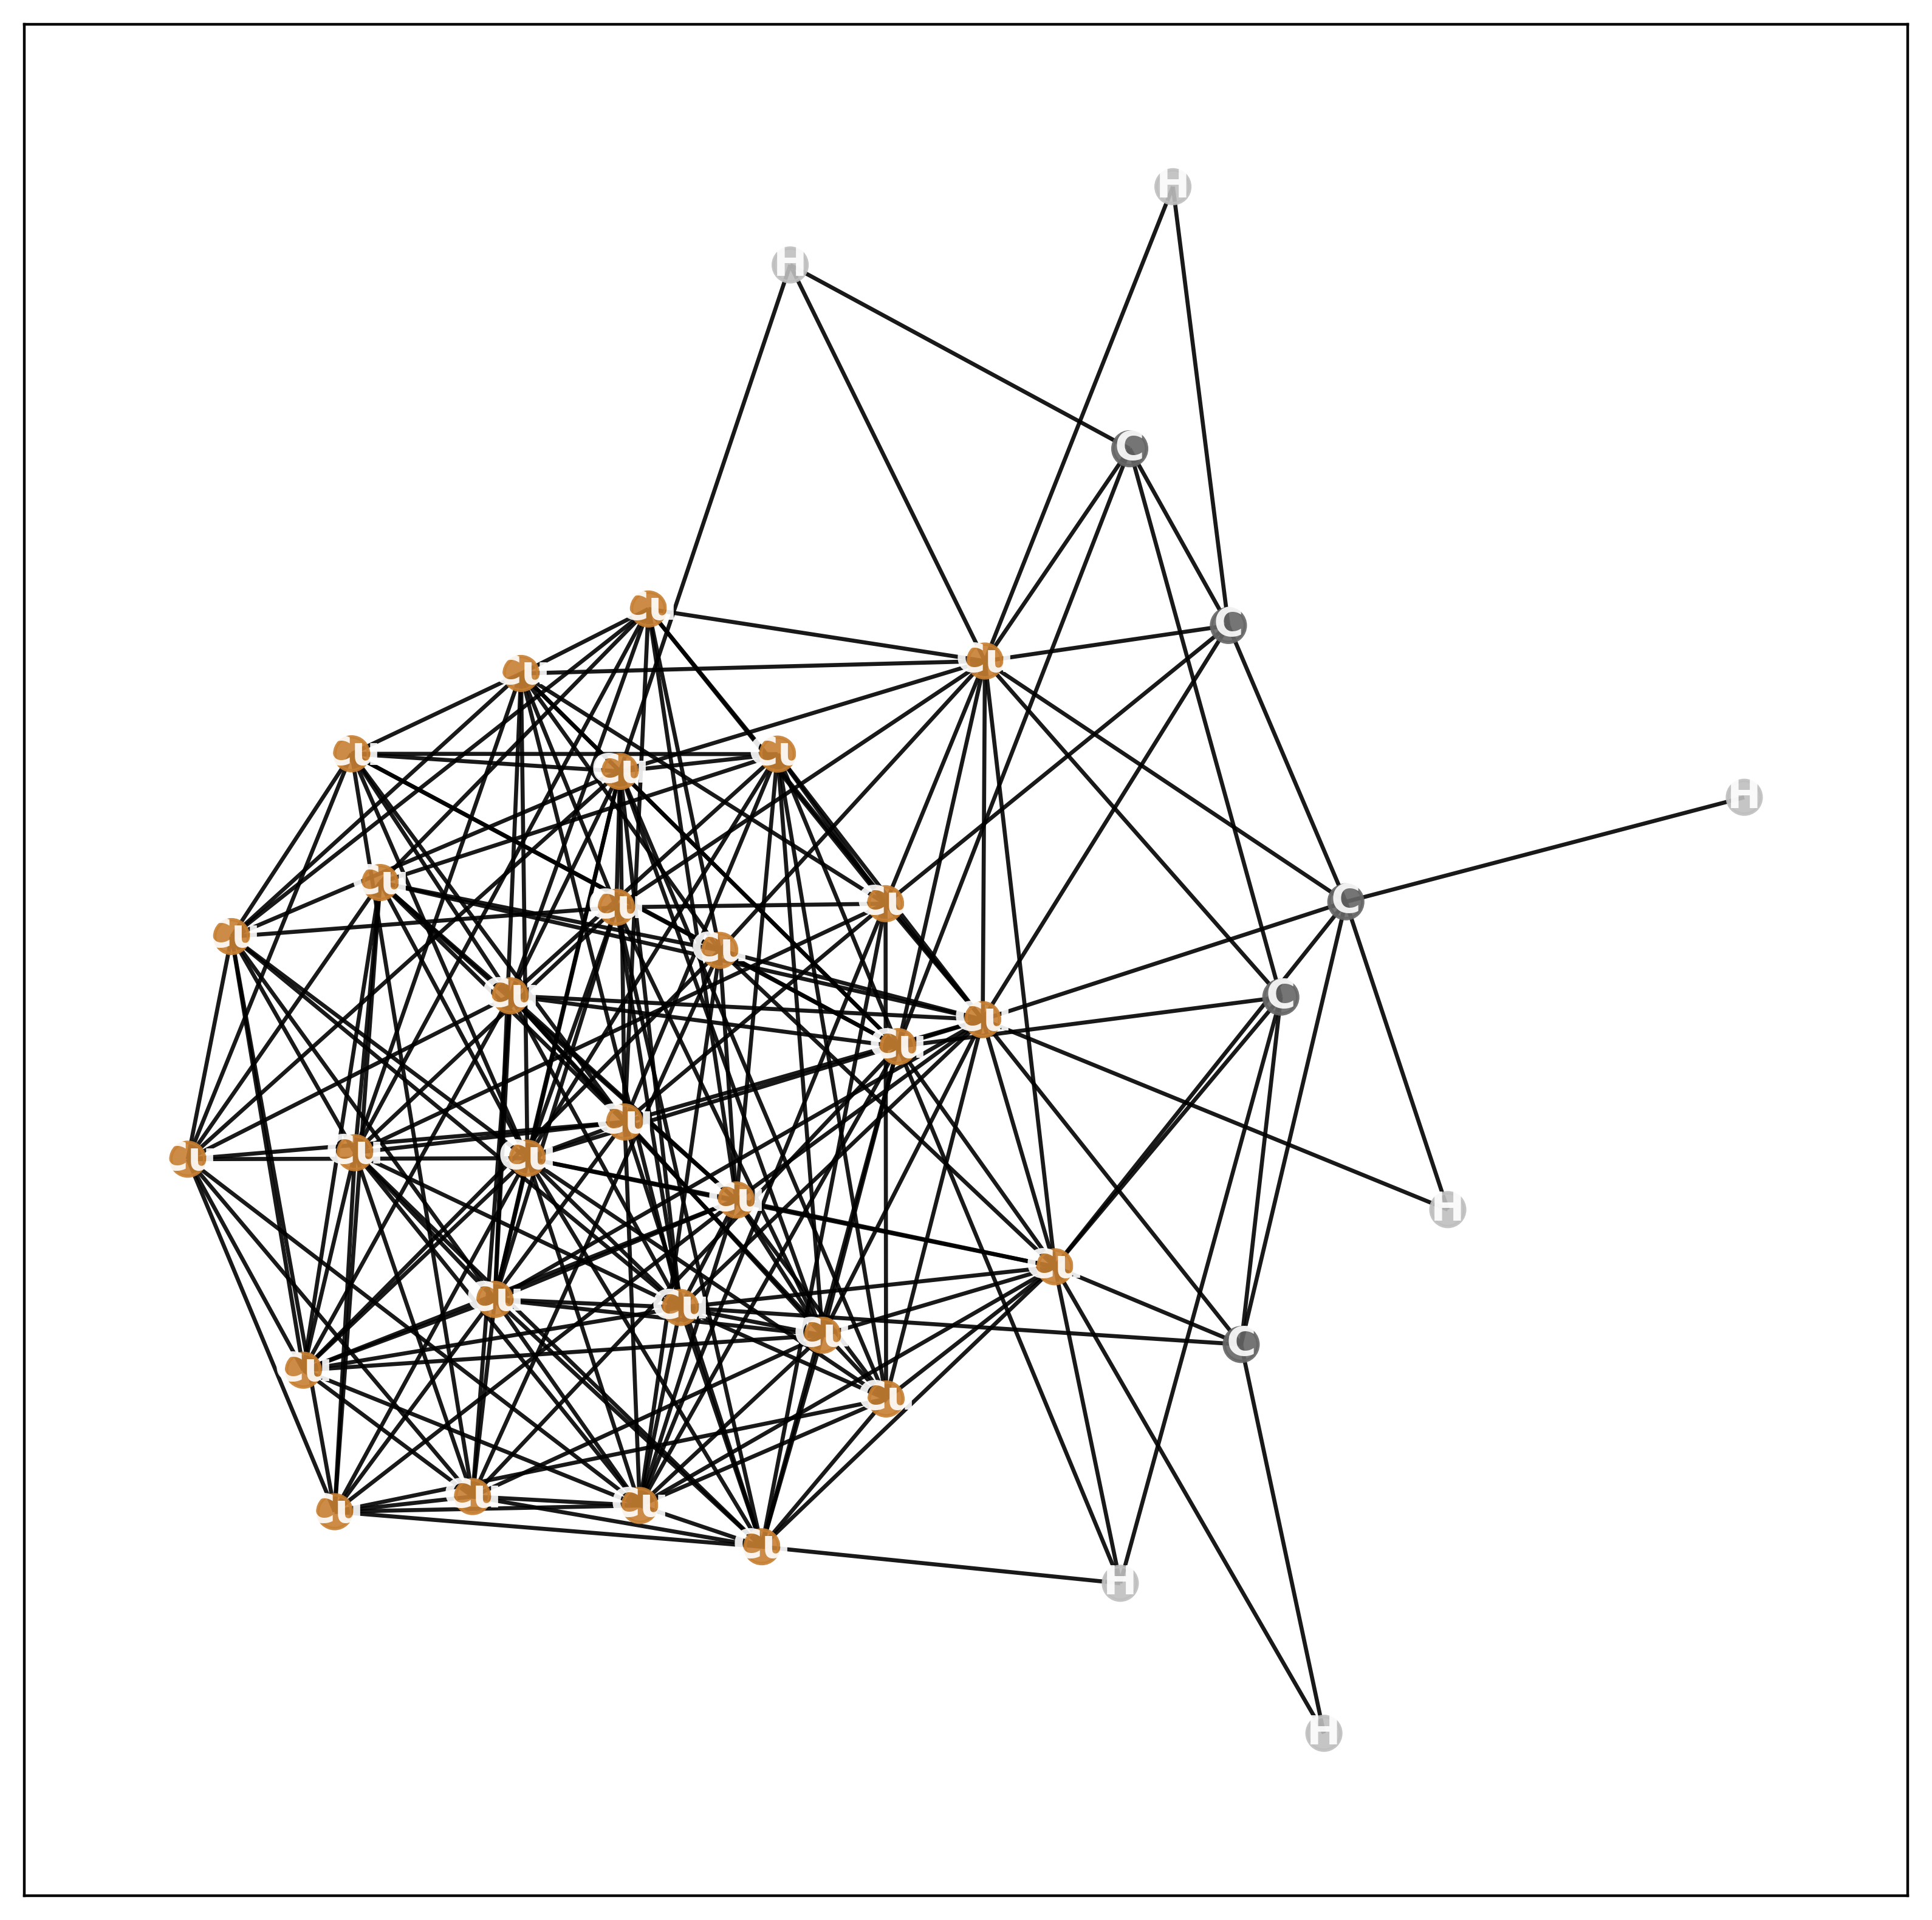

In [25]:
plotter(loader.dataset[440], dpi=400, node_size=100, figsize=(10,10))

In [17]:
test_graph = loader.dataset[3]
# for each node, print the element and the number of edges
for node in test_graph.edge_index[0]:
    print(test_graph.x[node], test_graph.edge_index[0].count(node))
    

AttributeError: 'Tensor' object has no attribute 'count'

In [27]:
import numpy as np
from itertools import product

mirrors = [-1, 0, 1]
mirrors = np.asarray(list(product(mirrors, repeat=3)))
mirrors = np.expand_dims(mirrors, 1)


In [33]:
mirrors = [-1, 0, 1]
list(product(mirrors, repeat=3))

[(-1, -1, -1),
 (-1, -1, 0),
 (-1, -1, 1),
 (-1, 0, -1),
 (-1, 0, 0),
 (-1, 0, 1),
 (-1, 1, -1),
 (-1, 1, 0),
 (-1, 1, 1),
 (0, -1, -1),
 (0, -1, 0),
 (0, -1, 1),
 (0, 0, -1),
 (0, 0, 0),
 (0, 0, 1),
 (0, 1, -1),
 (0, 1, 0),
 (0, 1, 1),
 (1, -1, -1),
 (1, -1, 0),
 (1, -1, 1),
 (1, 0, -1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, -1),
 (1, 1, 0),
 (1, 1, 1)]